# Dilated Networks for DNase- and ATAC-seq Footprinting - Hackathon

In this hackathon we will re-visit DNase- and ATAC-seq footprints. Both these assays highlight accesible (or open) regions of the genome. These regions coincide with regions that are important for gene regulation such as enhancer or promoters. When visualizing the full sequencing fragments this yields coverage plots with peaks over accessible regions. Usually we would call these peaks and take our analysis from their. In footprinting we visualize only the very tips of the fragments to resolve the actual cut site of the enzyme at basepair resolution. Regions within open chromatin sites that are bound by proteins are more protected from this cleavage then their surroundings, letting us discover footprints in the open chromatin. These fooptrints tend to associated with transcription factor binding sites allowing us to resolve them at higher resolution. However, not all transcription factors exhibit footprints, withi binding dynamics and sequence biases playing a key role. Interstingly, there is some debate in the field if ATAC-seq can be effectively used to derive footprints.

We will try to predict DNase-seq footprints from DNA sequence using dilated convolutional neural networks. We will also throw our models at ATAC-seq footprints and try to compare the two. I have prepared DNase-seq and ATAC-seq data from primary erythroid cells. Here is a [UCSC Genome Browser Session](http://genome-euro.ucsc.edu/s/rschwess/hg18_ngssummerschool_footprinting) to visualize the data we are dealing with. 

Points of (my) interest:

* Can we effectivly predict footprints from DNA at all?
* Can we do that for DNase- as well as ATAC-seq?
* Can we learn them jointly?
* How do they differ?
* Can we find the sequence determinants of footprints and do they differ between the experiments?
* Can we derive a an interpretation guide or even normalization method?

This hackathon is inspired by work on ChIPnexus models [BPnet]((https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view)) so their paper and their model architecture will be a good orientation. The keras documentation, Google and I are your best friends for the next two days ;).

This notebook is designed to give you a skeleton for your orientation and to get you started quickly. 

Note: The default notebook starts a python session without GPU support. Go to *Edit* -> *Notebook* Settings and select GPU as hardware accelerator. (Try with and without GPU notice the training speed difference?)


## Data

Lets start by downloading the data. I prepared DNase- and ATAC-seq footprints from primary erythroid data. These are centered on peak calls of the whole coverage signal. I prepared 200, 500 and 600 bp data sets but start with the 200 bp, as this shoudl contain the thick of transcription factor binding sites. I have also prepared strand-specific footprints as the signal tends to be slightly different depending on the strand and previous methods have often incorporated strand based modelling. Data from other tissues is also available if you get bored.

In [1]:
%%bash

# Download Data ----------------------------------------------------------------

rm -rf ./sample_data/

# Download raw data ------------------------------------------------------------
mkdir -p data

rm -f ./data/*

curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_dnase_200bp.txt >./data/data_raw_seq_and_fp_dnase_200bp.txt

# More Data -----------------
# DNase-seq
# curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_dnase_500bp.txt >./data/data_raw_seq_and_fp_dnase_500bp.txt
# curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_dnase_600bp.txt >./data/data_raw_seq_and_fp_dnase_600bp.txt

# ATAC-seq
# curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_atac_200bp.txt >./data/data_raw_seq_and_fp_dnase_200bp.txt
# curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_atac_500bp.txt >./data/data_raw_seq_and_fp_dnase_500bp.txt
# curl http://userweb.molbiol.ox.ac.uk//public/rschwess/ngssummerschool2019/data_raw_seq_and_fp_atac_600bp.txt >./data/data_raw_seq_and_fp_dnase_600bp.txt


# Create some directories and download helper scripts for later ----------------
mkdir -p helper visualize

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/functions_for_motif_plotting.R >./helper/functions_for_motif_plotting.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_weights_per_dir.R >./helper/plot_sequence_kernel_weights_per_dir.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_icms_per_dir.R >./helper/plot_sequence_kernel_icms_per_dir.R


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5M  100 12.5M    0     0  2188k      0  0:00:05  0:00:05 --:--:-- 3098k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18139  100 18139    0     0   120k      0 --:--:-- --:--:-- --:--:--  120k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1512  100  1512    0     0  23261      0 --:--:-- --:--:-- --:--:-- 23261
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1510  100  1510    0     0  23968      0 --:--:-- --:--:-- --:--:-- 23968


## Data format

In [2]:
%%bash

# inspect data in bash ----------------

head ./data/data_raw_seq_and_fp_dnase_200bp.txt


chr1	703893	704093	GGCCCACCTCTATGGTGTCGGCGAAGACCCGCCCTTGTGACGTCACGGAAGGCGCACCCTTGTGACGTCACAGGGGACTACCACTCACGCAGAGCCAATCAGAACTCGCGGTGGGGGCTGCTGGTTCTTCCAGGAGCGCGCATGAGCGGACGCTGCCTACTGGTGGCCGGGCGGGATGTAACCGGCTGCTGAGCTGGCAG	1,6,0,0,2,7,8,5,7,4,4,4,3,9,6,8,0,2,2,10,6,1,0,3,1,0,3,12,1,8,5,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4,5,1,2,1,14,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,21,11,4,1,27,11,6,6,6,2,15,4,4,1,6,6,3,1,2,2,8,3,0,2,1,3,1,5,3,3,0,2,1,0,1,2,1,6,1,5,3,1,3,7,7,1,9,6,5,1,6,0,2,9,3,1,3,2,1,1,1,0,2,1,0,1,3,4,1,1,3,1,1,1,5,6,0,4,1,4,1,4,2,0,1,4,2,3,4,3,1,3,2,1,0,6,3,1,2,3,9,2,7,4,6,0,1,1,2,1,4,3,1,3,3,0,4,3,1,2,1,0,5,3,0
chr1	752683	752883	ACTGCGTGGCTGGGTTTGGCCACAAAAAGCGGAGGGCACTCACCCGAGCGGACCTTGGCTCCGGATAATCCGTTTCCGGGTCAACAAAAAACGTCGCGCGAGGGGCGGGGCGCGTACGTGCAgggaggggaggcagagaaaaaggcggggccgggccgggccggggcggggtctcgggcaggggcggggAGCTTACCGAC	0,0,2,3,0,0,0,1,0,2,0,1,0,2,0,0,0,1,2,0,3,0,1,0,0,0,1,0,0,2,2,0,0,1,0,2,0,0,1,0,3,3,5,1,3,0,1,4,1,1,3,3,5,0,3,1,5,1,2,2,2,1,2,1,1,0,0,2,1,0,0,1,0,2,0,3,

Lets have a look at the data format first. Each row is a 200 bp region of the genome correpsonding to the center of an open chromatin peak. The columns are: chromosome start end sequence footprint_coverage. The footprint coverage is the raw count of fragment ends at the respective position which is comma separated.

Now moving to python and importing all modules we need for now.


In [3]:
# IMPORTING MODULES

import keras  # (you also import the whole of keras)
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


I wrote two helper functions to convert the sequences into hot encoded sequences and a wrapper to read in and assemble the footprint data. 

The hot encoding transforms each sequence into an 200 x 4 array whith rows corresponding to the sequence position and the columns representing the 4 DNA bases. The respective base column that matches the sequence at that position is 1 the rest 0.

The footprint data are converted to a 1 x 200 matrix with each column representing a relative position in the footprint.

Both sequences and fooptprints are then stacked up over all examples yielding a DATAPOINTS x 200 x 4 tensor for the sequence and DATAPOINTS x 200 matrix for the footprints.

By the way it's always good to keep track of your dimensions!

In [0]:
# Helper Function  get hotcoded sequence
def get_hot_coded_seq(sequence):
    """Convert a 4 base letter sequence to 4-row x-cols hot coded sequence"""
    # initialise empty
    hotsequence = np.zeros((len(sequence),4))
    # set hot code 1 according to gathered sequence
    for i in range(len(sequence)):
        if sequence[i] in ['A', 'a']:
            hotsequence[i,0] = 1
        elif sequence[i] in ['C', 'c']:
            hotsequence[i,1] = 1
        elif sequence[i]  in ['G', 'g']:
            hotsequence[i,2] = 1
        elif sequence[i]  in ['T', 't']:
            hotsequence[i,3] = 1
    # return the numpy array
    return hotsequence

# Helper function to read in the labels and seqs and store as hot encoded np array
# also store chromosomes and positions
def read_data(infile, lines=0):
  
  seqs = []
  labels = []
  chroms = []
  positions = []
  
  # read file in
  with open(infile, "r") as f:


      for i,l in enumerate(f):
          l = l.rstrip()
          l = l.split("\t")
          chroms.append(l[0])
          positions.append(l[1])
          seqs.append(l[3])
          labels.append(l[4])

          if i + 1 >= lines and lines != 0:
             break

  # convert footprints to numpy tensor
  footprints = np.zeros( (len(labels), SEQ_LENGTH) )

  for i in range(len(labels)):
    # convert labels to np.array
    fp = labels[i]
    fp = fp.split(",")
    fp = np.array(fp)        
    footprints[i,] = fp

  # make seqs np.array
  hot_seqs = np.zeros( (len(seqs), SEQ_LENGTH, 4) )

  # fill with hot encoded sequences
  for j in range(len(seqs)):
      hotsequence = get_hot_coded_seq(seqs[j])
      hot_seqs[j,] = hotsequence

  print('Successfully read in %s lines of Data.' % len(seqs))
  print('Sequences are stored in tensor with shape: ' + str(hot_seqs.shape))
  print('Footprints are stored in tensor with shape: ' + str(footprints.shape))

  return chroms, positions, seqs, hot_seqs, footprints



Next we set some global parameters and a random seed for reproducibility.

In [0]:
# Some GLOBAL PARAMETERS ----------
SEQ_LENGTH = 200

# set a seed 
np.random.seed(1234)

from tensorflow import set_random_seed
set_random_seed(1234)



Now we can read in the data from the raw files.


In [6]:
# read data --------------------------------------------------------------------
data_file = "./data/data_raw_seq_and_fp_dnase_200bp.txt"

chroms, positions, raw_seqs, data_seqs, data_footprints = read_data(data_file, lines = 0)  # lines == 0 to read all lines


Successfully read in 21012 lines of Data.
Sequences are stored in tensor with shape: (21012, 200, 4)
Footprints are stored in tensor with shape: (21012, 200)


Lets check how the data looks like after we read it into python and hot encoded the sequences and stored the footprints.

In [7]:
# Check Data in Python ---------------------------------------------------------

# check shapes
print("Seqs Shape", data_seqs.shape)
print("Footprints Shape", data_footprints.shape)

# check data format
print("Seq Format (first 10 bp):")
print(data_seqs[0:2, 1:10,:])

print("Footprints Format:")
print(data_footprints[0:2, 1:10])


Seqs Shape (21012, 200, 4)
Footprints Shape (21012, 200)
Seq Format (first 10 bp):
[[[0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]]
Footprints Format:
[[6. 0. 0. 2. 7. 8. 5. 7. 4.]
 [0. 2. 3. 0. 0. 0. 1. 0. 2.]]



The footprints are a 2D matrix with each row corresponding to a data point.

The sequences have shape [sample x sequence_length x base]. We encod the 4 DNA bases as "channels" a term borrowed from image analysis you will encounter a lot when working with tensorlfow. For comparison a set of 2D images would have the dimensions [sample x pixel_rows x pixel_columns x colour_channels]. A grey scale picture would have only one channel while RGB images have three. We can thus think of our sequence as a 1D image with 4 channels.

## Normalizing the Data?

At the moment the footprints are raw as they came out from the assay. We may want to normalize them (e.g. z-score scale them for example with "scipy.stats.zscore"). How would you normalize the data (row wise? colmun wise?)?  

## Spliting the Dataset

We want to split the data into training, validation and test sets. One option is to split all data points randomly into these sets given some proportion we decide. An alternative is to use some chromosomes for validation some for test and the rest for training.

Example for training and validation set only below, but think about which split you want to choose and implement.

In [8]:
# split based on fixed fractions ------------
from sklearn.model_selection import train_test_split

seqs_train, seqs_val, fps_train, fps_val = train_test_split(data_seqs, 
                                                            data_footprints, 
                                                            test_size=0.2, 
                                                            random_state=1234)

print('Training Seqs: ' + str(seqs_train.shape))
print('Validation Seqs: ' + str(seqs_val.shape))
print('Training Footprints: ' + str(fps_train.shape))
print('Validation Footprints: ' + str(fps_val.shape))

Training Seqs: (16809, 200, 4)
Validation Seqs: (4203, 200, 4)
Training Footprints: (16809, 200)
Validation Footprints: (4203, 200)


## Building the Network

We now define our network. We first set some global and network architecture options and put them all together in the keras sequential mode. The sequential mode is an easy wrapper for linearly stacked networks that makes your code even more concise. We just define the model to be sequential and than add/stack layer after layer. Here we use a dilated convolutional architecture. Nowadays the sequenctial model has a lot of functionality and possibilities implemented so it's good to stick with it to begin with. If we move towards more customization we may need to move to the model API mode.

I set out an example network architecture to get you started but your task is to find a much more suitable one!

Dilated networks are designed to have a large spatial reach without loosing resolution from max pooling. It is useful to calculate the spatial reach of your model architecture, which depends on the number of layers, their dilation rates and the kernel/filter width. I wrote a helper function to make this more quick.

Usually, dilation rates are doubled per layer you add and people often use multiple "stacks" where you use a repetitive structure (e.g. 1,2,4,8,1,2,4,8). 



In [0]:
def calc_spatial_range(width, scheme):
  w = 0
  for i in scheme:
    w = w + (width - 1) * i    
  return w


In [27]:
# Define the Model Architecture ------------------------------------------------
# global options
num_classes = SEQ_LENGTH

# network architecture options
first_layer_hidden_units = 5
dilated_hidden_units = 10
dilated_kernel_size = 3
dilation_scheme = [2,4,8,16,32,64,1]

print("Spatial range: " + str(calc_spatial_range(3, dilation_scheme)))

# construct the model ----------------------------------------------------------
model = Sequential()
model.add(Conv1D(first_layer_hidden_units, 
                 kernel_size=(20), 
                 dilation_rate=1, 
                 activation='relu', 
                 input_shape=(SEQ_LENGTH, 4), 
                 padding='same'))
for d in dilation_scheme:
  model.add(Conv1D(dilated_hidden_units, 
                   kernel_size=(dilated_kernel_size), 
                   dilation_rate=1, 
                   activation='relu',
                   padding='same'))
  # model.add(Dropout(0.1))   # try with and without dropout!
  
model.add(Flatten())
model.add(Dense(SEQ_LENGTH)) # no activation -> linear activation a(x) = x

Spatial range: 254


Compile the model and print a summary. Check the dimensions!

In [28]:
# compile ----------------------------------------------------------------------
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# print model summary ----------------------------------------------------------
model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 200, 5)            405       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 200, 10)           160       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 200, 10)           310       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 200, 10)           310       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 200, 10)           310       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 200, 10)           310       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 200, 10)          

## Training

Now that we have our model set up we can train it. We feed the model with our training sequences and labels, we define a batch size (since we are training in batch mode) and set the number of epochs (cycles through the training data) we want to train for. Five epochs should be fine for us feel free to ramp this up a bit and see if you get improvements or if the learning plateus quickly.

In [29]:
# Training Options
batch_size = 10
epochs = 3

# Train ------------------------------------------------------------------------
history = model.fit(seqs_train, fps_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(seqs_val, fps_val))

Train on 16809 samples, validate on 4203 samples
Epoch 1/3
16809/16809 [==============================] - 13s 802us/sample - loss: 4.0606 - acc: 0.0140 - val_loss: 3.6684 - val_acc: 0.0214
Epoch 2/3
16809/16809 [==============================] - 13s 784us/sample - loss: 3.9190 - acc: 0.0319 - val_loss: 3.6095 - val_acc: 0.0359
Epoch 3/3
16809/16809 [==============================] - 13s 774us/sample - loss: 3.8217 - acc: 0.0468 - val_loss: 3.5914 - val_acc: 0.0428


You will notice that we stored the training output in a **history** variable. We can use this variable to monitor the loss function and accuracy over the training progress.

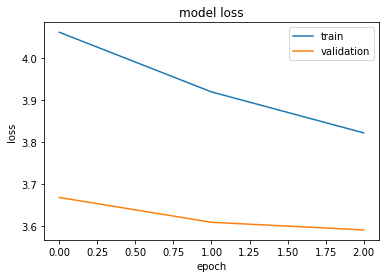

In [31]:
# Plot Training and Validation Loss ------------------------------
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# # Plot Training and Validation Accuracy ------------------------------
# plt.figure()
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'])
# plt.show()



Test on an example.


In [32]:
# Predictions ------------------------------------------------------------------

i = 111

# select a single sequence
single_seq = raw_seqs[i]
single_hot_seq = data_seqs[i,:,:]

single_fps = data_footprints[i,:]

# single_hot_seq = seqs_val[i,:,:]
# single_fps = fps_val[i,:]

print(single_seq)

# Run a single prediction 
single_prediction = model.predict(np.expand_dims(single_hot_seq, axis=0))

print(single_prediction.shape)  # check shape

# print first 10 entires of actual footprint and prediction
print('Footprint: ' + str(single_fps[0:10]))
print('Predicted: ' + str(single_prediction[:,0:10]))


CCGCGGCGGAGCTGCTGCACCGACCCGCCGCCCACTCCCCGCTCGGGCCCGGCCCACCTCGCAGTATCGCGCCCCTCCATTGGTACAGCGCGGTGTGACGCGGCCGGGGGCCCGGCCAATGGGAGGCGGAGGAGGCGGGATCTCtttttccttttttttttttttttttttttttttttAATCTTTTTAATAAAATGAGC
(1, 200)
Footprint: [2. 0. 0. 0. 1. 2. 3. 0. 1. 2.]
Predicted: [[0.86805755 0.59707195 0.5970783  0.68230057 0.37703478 0.85905963
  0.8762216  0.41787606 1.0481064  1.581926  ]]


## Visualize Footprints

Text(0.5, 1.0, 'Prediction')

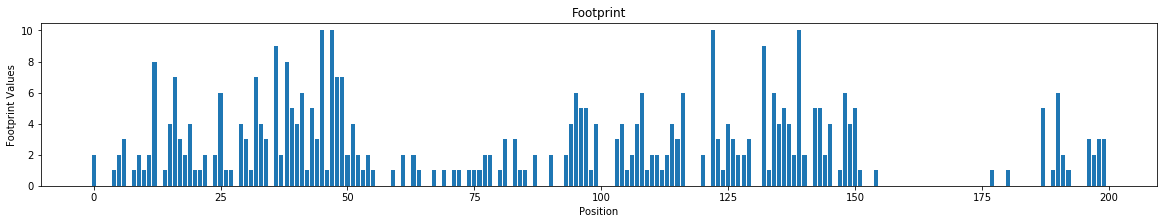

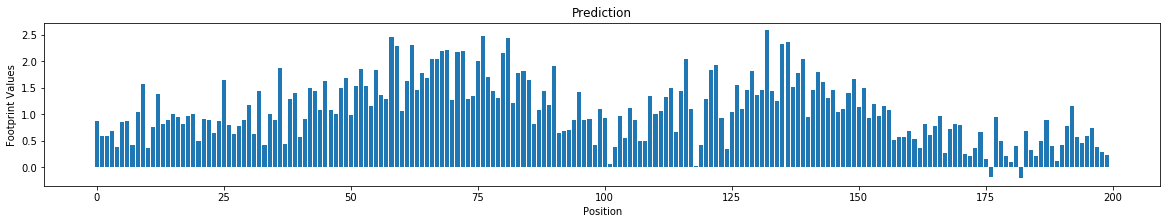

In [33]:
# Visualize Footprints ---------------------------------------------------------
plt.figure(figsize=[20,3])
barlist = plt.bar(np.arange(200), single_fps)
plt.xlabel('Position')
plt.ylabel('Footprint Values')
# plt.xticks(np.arange(200), list(single_seq))
plt.title('Footprint')

plt.figure(figsize=[20,3])
barlist = plt.bar(np.arange(200), single_prediction[0,:])
plt.xlabel('Position')
plt.ylabel('Footprint Values')
# plt.xticks(np.arange(200), list(single_seq))
plt.title('Prediction')




##Inspecting Learned Filters

Now that we have a reasonably working model, we also want to inspect and see what the net has learned. In applications, we often don't care what the network has learned as long as it performs well and outperforms our competitors. For many research problems however, we are exactly interested in what the network has learned. What features distinguish a cat from a dog or if it comes to decision making (e.g. health care or self driving cars), we obviously want to be able to understand and be able to justify why a certain decision has been chosen and learn how to correct missbehavior.

In genomics we usually want to learn what sequence features distinguish the sequences from one another and map them back to biological properties and factors. The easiest way is to just plot the filter weights. In the first convolutional layer, our filters are just like position weight matrices, multiplying every base at every position with a learned weight and summing the value up (plus a bias and pipe it through the RELU activation function). Unfortunatly, this becomes less straight forward to interpret in deeper layers. There are ways of back engineering and learning the importance of filters in higher layers (e.g. https://github.com/kundajelab/deeplift) but we concern ourself only with the simple first layer here.

We can get the weigths of the filters from the model, save them as .txt files and plot them out. I wrote a wrapper to plot the filter weigths for you in R. Run the code, check the filter_X.txt files and look at the plots and try to interpret them. In Colab runs you probaly want to download them.

* Do any look like transciption factor binding sites you know?
* Do you recognize any sequence features that are not binding motifs?
* Can you simplify the sequences/ motifs from the plot an query them in a transcription factor binding motif database (http://jaspar.genereg.net/)
* What is your best bet: Which sequence motifs did we use for simulating the sequence classes?
* Check the input data. Split them up by class into text files with only the sequences one sequence per line (see example). Query them in standard motif analysis tools (e.g. http://rsat.sb-roscoff.fr/oligo-analysis_form.cgi or http://meme-suite.org/tools/meme). Do these tools find different or similar things?

NOTE: This script will be reasonably slow for a large number filters.


In [0]:
# Inspect weights --------------------------------------------------------------
model_weights = model.get_weights()
filter_weights = model_weights[0]

# save conv filter weights
for k in range(model_weights[0].shape[2]):
    # save single filter weights
    np.savetxt(("./visualize/filter_%s.txt" % k), filter_weights[:,:,k], delimiter="\t")

In [0]:
%%bash

# Plot them using the supplied R script
Rscript ./helper/plot_sequence_kernel_weights_per_dir.R ./visualize ./visualize plot_weight 5 2.5

Process is interrupted.


Now thay don't look the nice motifs with information content we are used to look at from ChIP-seq analysis and such. Our filters have positive and negative values all contributing to the "matching score" of a filter at a given position. In contrast, information content motifs don't have negative values just less informative bases that occur less often in a, let's say, binding site. Luckily there is a [transformation](https://www.biorxiv.org/content/10.1101/163220v2) we can apply to the filter weights to derive information content. For our purposes her just use the helper script that implements the transformation.

In [0]:
%%bash

# Plot ICM like motifs using the supplied R script
Rscript ./helper/plot_sequence_kernel_icms_per_dir.R ./visualize ./visualize plot_motif 5 2.5

 [1] "filter_0.txt"  "filter_1.txt"  "filter_10.txt" "filter_11.txt"
 [5] "filter_12.txt" "filter_13.txt" "filter_14.txt" "filter_15.txt"
 [9] "filter_16.txt" "filter_17.txt" "filter_18.txt" "filter_19.txt"
[13] "filter_2.txt"  "filter_20.txt" "filter_21.txt" "filter_22.txt"
[17] "filter_23.txt" "filter_24.txt" "filter_25.txt" "filter_26.txt"
[21] "filter_27.txt" "filter_28.txt" "filter_29.txt" "filter_3.txt" 
[25] "filter_30.txt" "filter_31.txt" "filter_32.txt" "filter_33.txt"
[29] "filter_34.txt" "filter_35.txt" "filter_36.txt" "filter_37.txt"
[33] "filter_38.txt" "filter_39.txt" "filter_4.txt"  "filter_40.txt"
[37] "filter_41.txt" "filter_42.txt" "filter_43.txt" "filter_44.txt"
[41] "filter_45.txt" "filter_46.txt" "filter_47.txt" "filter_48.txt"
[45] "filter_49.txt" "filter_5.txt"  "filter_6.txt"  "filter_7.txt" 
[49] "filter_8.txt"  "filter_9.txt" 
[1] "Saving Plot filter_0.png"
[1] "Saving Plot filter_1.png"
[1] "Saving Plot filter_10.png"
[1] "Saving Plot filter_11.png"
[1] "Savi

A little wrapper to zip all plots and filter weigths into a tar.gz. Gownload them from the files menu.

In [0]:
%%bash

tar czvf visualize.tar.gz ./visualize 

./visualize/
./visualize/filter_37.txt
./visualize/plot_motif_filter_25.png
./visualize/plot_motif_filter_0.png
./visualize/filter_5.txt
./visualize/plot_motif_filter_15.png
./visualize/filter_38.txt
./visualize/plot_motif_filter_6.png
./visualize/filter_19.txt
./visualize/filter_0.txt
./visualize/plot_motif_filter_48.png
./visualize/filter_1.txt
./visualize/filter_47.txt
./visualize/plot_motif_filter_49.png
./visualize/filter_17.txt
./visualize/plot_motif_filter_37.png
./visualize/plot_weight_filter_10.png
./visualize/plot_motif_filter_4.png
./visualize/plot_motif_filter_3.png
./visualize/filter_34.txt
./visualize/plot_motif_filter_11.png
./visualize/plot_motif_filter_10.png
./visualize/plot_motif_filter_5.png
./visualize/filter_3.txt
./visualize/plot_motif_filter_44.png
./visualize/filter_45.txt
./visualize/filter_40.txt
./visualize/filter_28.txt
./visualize/filter_24.txt
./visualize/filter_46.txt
./visualize/filter_21.txt
./visualize/plot_motif_filter_12.png
./visualize/plot_motif_f

## Visualize Importance

A popular approach to visualize and start to interpret the importance of sequence features is the so called **Saliency**. This term has been introduced to descripe the gradient of the model output with respect to a sequence input. In other words, how much would the prediction change if we were to change a single base pair. Here change mean changing the *1* in the hot encoding to a marginally different value e.g. *1.00001*. 


I nicked this function and visualization was adapted from the James Zhou's [Primer on Genomics](https://colab.research.google.com/drive/17E4h5aAOioh5DiTo7MZg4hpL6Z_0FyWr#scrollTo=WNT_Au-dAP8a) colab notebook. Check it out and the paper is worth a read.


In summary, what we are doing here is calculating the gradient of the model ouput with respect to a single sequence input. We then multiply this gradient with the one hot endoded sequence, effectively zeroing all non present bases, and then sum this over the 4 output classes and trim everything below zero (for pure ease of visualization).

In [0]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output, model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  gradients = compute_gradients([x])[0][0]
  x = np.squeeze(x, axis = 0)  
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  
  return sal

In [0]:
# use a single sequence again (index 1 works well)
selected_index = 10000

single_seq = raw_seqs[selected_index]

# hot encode        
hotseq = get_hot_coded_seq(single_seq)

hotseq = np.expand_dims(hotseq, axis=0)

# calculate predictions
single_prediction = model.predict(hotseq)

print("Prediction: %s" % single_prediction[0, 0:10])

print("True Label: %s" % data_footprints[selected_index,0:10])


Prediction: [0.9427324 1.1587527 1.2086455 1.0837033 1.2156385 1.3716241 1.3836886
 1.4744886 1.4704169 0.9700161]
True Label: [1. 2. 0. 1. 0. 0. 1. 0. 0. 0.]


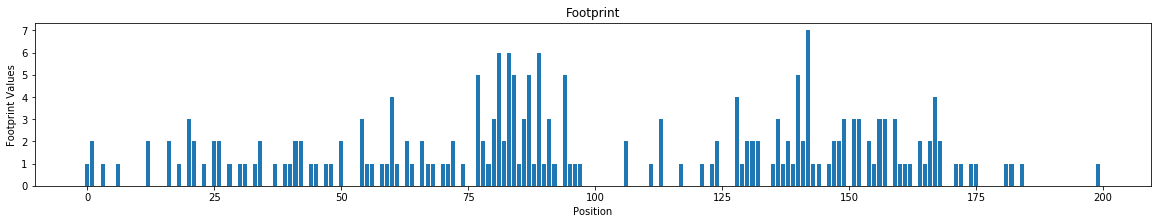

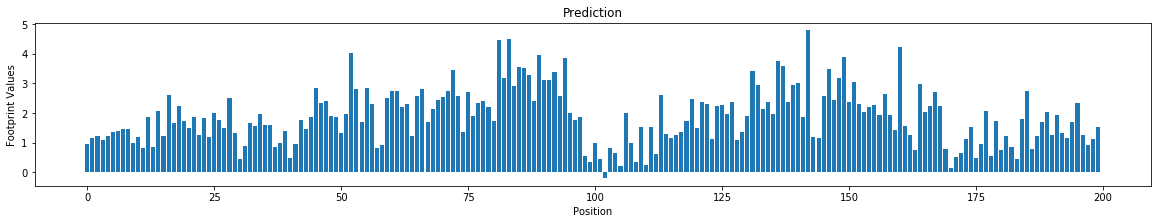

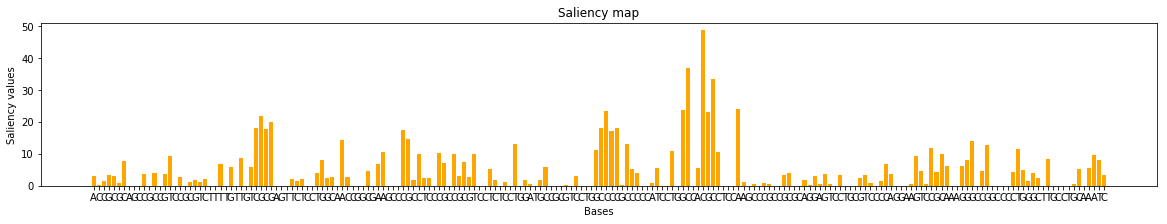

In [0]:
sal = compute_salient_bases(model, hotseq)

plt.figure(figsize=[20,3])
barlist = plt.bar(np.arange(200), data_footprints[selected_index,:])
plt.xlabel('Position')
plt.ylabel('Footprint Values')
# plt.xticks(np.arange(200), list(single_seq))
plt.title('Footprint')

plt.figure(figsize=[20,3])
barlist = plt.bar(np.arange(200), single_prediction[0,:])
plt.xlabel('Position')
plt.ylabel('Footprint Values')
# plt.xticks(np.arange(200), list(single_seq))
plt.title('Prediction')

plt.figure(figsize=[20,3])
barlist = plt.bar(np.arange(len(sal)), sal, color='orange')
plt.xlabel('Bases')
plt.ylabel('Saliency values')
plt.xticks(np.arange(len(sal)), list(single_seq));
plt.title('Saliency map');

## Where to go from here

A collection of thoughts and hints to best practises worth to consider for implementation. 

* Keep track of your dimensions!

* Try to optimize the network architecture

* Try to optimize the hyperparameters:
  * Architectural: Filter widths, number of layers, dilation scheme, ...
  * Learning process: Learning rate, optimizer, dropout rate, L2 norm strength ...
  * It's usually a good Idea to do that once (or only a few times) but systematically
  * Ask me about grid search and baysian hyperparameter optimization

* Add Dropout layers, L2 norm and/or other regularization

* It's a good idea to shuffle the training data after every epoch to feed a new combination of batches in the enxt run!

* If training sequences are somewhat limited, you can use the reverse complement of a sequence as additional data points. **Be careful how you split the train, validation and test data then!** Contemplate how this can lead to overfitting!
* You can also increase the number of training examples by shifting the examples to the left or right. I have prepared 500 and 600 bp raw data which should give you plenty of space to play with. Same overfitting concerns as above apply.

* Check out [BPNet](https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view), they are doing something very similar with ChIPnexus data. Get inspired (or copy) their architecture. They have a [github page](https://github.com/kundajelab/bpnet) with their implementation.

* Check out residual blocks!

* Compare our output vector to BPnet approach!

* So far we've been working in kera's [sequential mode](https://keras.io/getting-started/sequential-model-guide/). For more bespoke implementations you may need to switch to [model mode](https://keras.io/getting-started/functional-api-guide/)

* Ask me about strand specific data! 

* Ask me about ATAC-seq data!

  * try to predict ATAC-seq footprints
  * build a joint model? predict data source as well?

* Ask me about other tissues!